# Azure OpenAI Assistants - Code Interpreter

This notebook will find answers to a data set:
1. If 1 row in the dataset is 1 sighthing, what's our total sightings?
2. Which state has the most sightings?
3. Which season has the most sightings?
4. What are the top 10 years with the most sightings?
5. How many sightings did we have for Washington state in the year 2000?

Answers:
1. 5021
2. Washington (601)
3. Summer
4. 2004, 2005, 2006, 2003, 2000, 2007, 2008, 2012, 2001, 2011
5. 28

## Install Dependencies

In [ ]:
%pip install openai

## Load Azure Configuration

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT")
azure_openai_api_version = "2024-10-01-preview"

## Step 1-2:
1. Create an Assistant
2. Create a Thread

In [2]:
from openai import AzureOpenAI
import time

# Create an AzureOpenAI client
client = AzureOpenAI(
  azure_endpoint = azure_openai_endpoint,
  api_key= azure_openai_key,
  api_version=azure_openai_api_version
)

# Create a file
file = client.files.create(
  file=open("../Data/assistant/bigfootsightings.csv", "rb"),
  purpose='assistants'
)

# STEP 1: Create an assistant
assistant = client.beta.assistants.create(
  model=azure_openai_deployment,
  name="bigfootsightings",
  instructions="""You are an assistant answering questions about bigfootsightings dataset.""",
  tools=[{"type":"code_interpreter"}],
  tool_resources={"code_interpreter":{"file_ids":[file.id]}},
  temperature=1,
  top_p=1, 
)

# STEP 2: Create a thread
thread = client.beta.threads.create()


## Step 3-6: 
3. Add a message to the thread
4. Run the Assistant
5. Check the Run Status
6. Display the Assistant's Response

In [3]:
PROMPT_SUFFIX = """
- **ALWAYS** before giving the Final Answer, try another method.
Then reflect on the answers of the two methods you did and ask yourself
if it answers correctly the original question.
If you are not sure, try another method.
- If the methods tried do not give the same result,reflect and
try again until you have two methods that have the same result.
- If you still cannot arrive to a consistent result, say that
you are not sure of the answer.
- If you are sure of the correct answer, create a beautiful
and thorough response using Markdown.
- **DO NOT MAKE UP AN ANSWER OR USE PRIOR KNOWLEDGE,
ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE**.
- **ALWAYS**, as part of your "Final Answer", explain how you got
to the answer on a section that starts with: "\n\nExplanation:\n".
In the explanation, mention the column names that you used to get
to the final answer and provide the python code you used.

"""

user_question ="""If 1 row in the dataset is 1 sighting, what's our total sightings
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)


SyncCursorPage[Message](data=[Message(id='msg_JMHTBpaw4c47EYSPsP196Y4Q', assistant_id='asst_wT83rcvLcpQeIrKNFZztwQJ0', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='The dataset contains a total of **5,021 sightings** of Bigfoot.\n\n### Explanation:\nTo arrive at this answer, I considered that each row in the dataset corresponds to one sighting. Therefore, I simply counted the number of rows in the dataset using the `len()` function in Python.\n\nHere is the code I used:\n```python\ntotal_sightings = len(data)\n```\n\nThus, we conclude that the total number of sightings is **5,021**.'), type='text')], created_at=1734494112, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_a9O3x7qrTohEZE2xVGQCpMLR', status=None, thread_id='thread_NbM49cMV49IpjFuquPjrHSU4'), Message(id='msg_Wj1HD5OrHfQksp9T9P0PN9zb', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock

## Step 7: Appending Messages to the thread

In [4]:
user_question ="""Which state has the most sightings? Provide the number of sightings in that state
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_VX4Q7nJ79WfEjDb0RWDvNciS', assistant_id='asst_wT83rcvLcpQeIrKNFZztwQJ0', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="The state with the most sightings of Bigfoot is **Washington**, with a total of **601 sightings**.\n\n### Explanation:\nI determined the state with the most sightings by counting the occurrences of each state in the `state` column. This was done using two methods:\n\n1. The first method utilized the `value_counts()` function, which provides counts of unique values in the `state` column. I then identified the state with the maximum count.\n   \n   Here is the code I used:\n   ```python\n   sightings_per_state = data['state'].value_counts()\n   most_sightings_state = sightings_per_state.idxmax()\n   most_sightings_count = sightings_per_state.max()\n   ```\n\n2. The second method employed the `groupby()` function combined with the `size()` method to achieve the same result by gro

In [5]:
user_question ="""Which season has the most sightings?
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_KQMQToHTuwxiSruYGMEtGlXi', assistant_id='asst_wT83rcvLcpQeIrKNFZztwQJ0', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="The season with the most sightings of Bigfoot is **Summer**, with a total of **1,867 sightings**.\n\n### Explanation:\nI determined the season with the most sightings by counting the occurrences of each season in the `season` column. This was achieved using two methods:\n\n1. The first method used the `value_counts()` function, which lists the count of unique values in the `season` column. I then identified the season with the maximum count.\n   \n   Here is the code I used:\n   ```python\n   sightings_per_season = data['season'].value_counts()\n   most_sightings_season = sightings_per_season.idxmax()\n   most_sightings_season_count = sightings_per_season.max()\n   ```\n\n2. The second method involved grouping the dataset by the `season` column and counting the entries using t

In [11]:
user_question ="""
What are the top 10 years with the most sightings? 
Use the date column and get the year there.
Create a bar chart with the sightings in the Y-axis and years in the X-axis and save it to a file named top10.png.
Put the value on top of each bar
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
#value = content_block.text.value
#print(value)

SyncCursorPage[Message](data=[Message(id='msg_B514qeDxDcM5MiO0o9QEShGo', assistant_id='asst_wT83rcvLcpQeIrKNFZztwQJ0', attachments=[Attachment(file_id='assistant-pRitgNBp5Nrv7MgP918du2Vl', tools=[CodeInterpreterTool(type='code_interpreter')])], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='assistant-ngTVTiqXzs0e3sIOAmOAL2M2', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[FilePathAnnotation(end_index=673, file_path=FilePath(file_id='assistant-pRitgNBp5Nrv7MgP918du2Vl'), start_index=646, text='sandbox:/mnt/data/top10.png', type='file_path')], value="The bar chart illustrating the top 10 years with the most Bigfoot sightings has been successfully generated once more, confirming the previous results.\n\n### Top 10 Years with Most Bigfoot Sightings\n\n| Year | Number of Sightings |\n|------|---------------------|\n| 2004 | 241                 |\n| 2005 | 209                 |\n| 2006 | 176                 |\n| 2003 | 152         

### Retrieve image output

In [12]:
print(content_block)

ImageFileContentBlock(image_file=ImageFile(file_id='assistant-ngTVTiqXzs0e3sIOAmOAL2M2', detail=None), type='image_file')


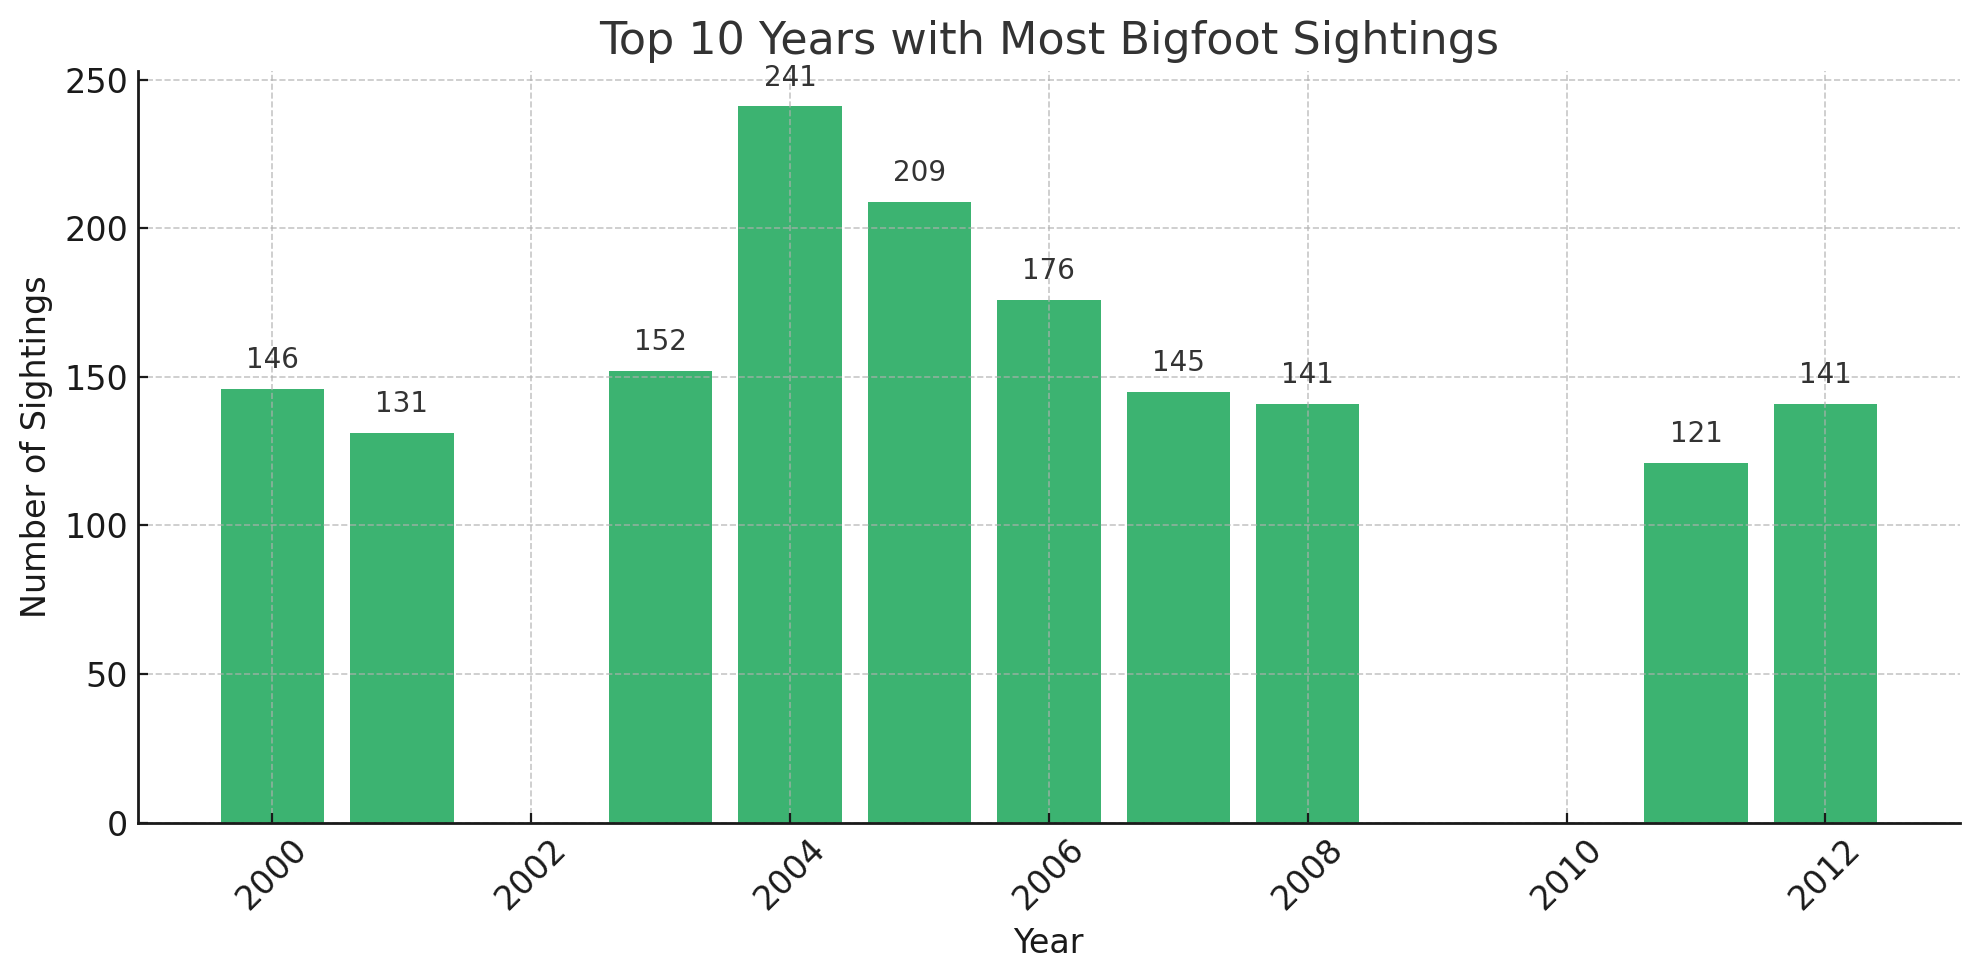

In [15]:
from PIL import Image
# enter the file_id inside content example: "assistant-fYrZ85PwbViKU9mrVoE8dqBO"
image_data = client.files.content("assistant-ngTVTiqXzs0e3sIOAmOAL2M2")
image= image_data.write_to_file("top10.png")

# Display the image in the default image viewer
image = Image.open("top10.png")
image.show()

In [ ]:
user_question ="""How many sightings did we have for Washington state in the year 2000?
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

In [16]:
user_question ="""Using the "observed" column, are there any sightings observed at Mt. Mitchell?
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_2KUhhVsxUF3ltNpjH8tCkt4i', assistant_id='asst_wT83rcvLcpQeIrKNFZztwQJ0', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='There is **1 sighting** observed at Mt. Mitchell.\n\n### Explanation:\nTo determine if there are any sightings recorded at Mt. Mitchell using the "observed" column, I performed the following steps:\n\n1. **Filtered Observations**: I searched the `observed` column for entries that contain the phrase "Mt. Mitchell". This was done using the `str.contains()` method in Pandas, which allows for string matching within a Series.\n\n2. **Counted Results**: I counted the number of sightings that matched this filtering criteria.\n\nHere is the Python code used for this analysis:\n```python\nmt_mitchell_sightings = data[data[\'observed\'].str.contains("Mt. Mitchell", na=False)]\nnumber_of_sightings = len(mt_mitchell_sightings)\n```\n\nThe result confirms that there is indeed **1 sighting*

## Delete Assistant

In [17]:
response = client.beta.assistants.delete(assistant.id)